In [1]:
import argparse
import itertools
import math
import os
from multiprocessing import Value
import toml

from tqdm import tqdm
import torch
import transformers

/home/harshb/miniconda3/envs/sdxl_3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/harshb/miniconda3/envs/sdxl_3.10/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
from accelerate.utils import set_seed
from diffusers import DDPMScheduler

/home/harshb/miniconda3/envs/sdxl_3.10/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/harshb/miniconda3/envs/sdxl_3.10/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


### Prepare Dataset

In [81]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pathlib
from PIL import Image, UnidentifiedImageError
import numpy as np


transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512))
])
instance_prompt = "zwx man"
class_prompt = "a headshot of a man"
prior_loss_weight = 1.0


class DreamBoothDataset(Dataset):
    def __init__(self, data_dir, reg_dir, transforms, tokenizer, instance_prompt, class_prompt):
        self.instance_images = self.load_images(data_dir)
        self.reg_images = self.load_images(reg_dir)
        self.transforms = transforms
        self.tokenizer = tokenizer
        self.instance_prompt = instance_prompt
        self.class_prompt = class_prompt
        self._length = max(len(self.reg_images), len(self.instance_images))
        

    def load_images(self, data_dir):
        images = [] 
        for img_path in tqdm(pathlib.Path(data_dir).glob("*")):
            try:
                img = Image.open(img_path)
                images.append(np.array(img))
            except UnidentifiedImageError:
                print(f"Error: {img_path} is not a valid image file.")
            except Exception as e:
                print(f"An error occurred while opening {img_path}: {e}")
        return images

    def process_text(self, tokenizer, input_text):
        max_length = tokenizer.model_max_length
        text_input = tokenizer(
        input_text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
        )
        return text_input['input_ids']

    def __len__(self):
        return self._length

    def __getitem__(self, idx):
        if idx % 2 == 0:
            img = self.instance_images[idx % len(self.instance_images)]
            input_ids = self.process_text(self.tokenizer, self.instance_prompt)
        else:
            reg_idx = torch.randint(0, len(self.reg_images), (1,)).item()
            img = self.reg_images[reg_idx]
            input_ids = self.process_text(self.tokenizer, self.class_prompt)
        if self.transforms:
            img = transforms(img)
        
        return img, input_ids

### Download the SD model

In [82]:
from huggingface_hub import snapshot_download

model_dir = snapshot_download('wavymulder/Analog-Diffusion', local_dir="./Analog-sd1.5")

Fetching 23 files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 4191.57it/s]


### Generate Reglarization Images

In [83]:
from pathlib import Path
from diffusers import StableDiffusionPipeline


reg_dir = Path("./reg_dir")
num_reg_images = 50
batch_size = 4
# if not reg_dir.exists() or len(list(reg_dir.glob("*.jpg"))) < num_reg_images:
#     pipeline = StableDiffusionPipeline.from_pretrained(model_dir).to('cuda')
#     reg_dir.mkdir(exist_ok=True)
#     for i in range(num_reg_images // batch_size):
#         if i == (num_reg_images // batch_size)-1 :
#             images = pipeline(class_prompt, num_images_per_prompt=num_reg_images % batch_size).images
#         else:
#             images = pipeline(class_prompt, num_images_per_prompt=batch_size).images

#         [img.save(f'{reg_dir}/{i}_{j}.jpg') for j, img in enumerate(images)]

In [84]:
# load tokenizer
from transformers import CLIPTokenizer, CLIPTextModel

tokenizer = CLIPTokenizer.from_pretrained('./Analog-sd1.5/tokenizer')
tokenizer

CLIPTokenizer(name_or_path='./Analog-sd1.5/tokenizer', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [85]:
dataset = DreamBoothDataset('./harsh_photos', reg_dir, transforms, tokenizer, instance_prompt, class_prompt)
len(dataset)

17it [00:00, 19.23it/s]
46it [00:00, 881.74it/s]


46

In [86]:
train_dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=8
)

In [87]:
device = 'cuda'

### Define Tensor Presicion

In [88]:
dtype = torch.float16

### Load Text Encoder, Unet And VAE

In [89]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained('./Analog-sd1.5').to('cuda')

vae = pipe.vae
text_encoder = pipe.text_encoder
unet = pipe.unet

vae, text_encoder, unet

Loading pipeline components...:   0%|                                                                                                                                                    | 0/7 [00:00<?, ?it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.23it/s]


(AutoencoderKL(
   (encoder): Encoder(
     (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (down_blocks): ModuleList(
       (0): DownEncoderBlock2D(
         (resnets): ModuleList(
           (0-1): 2 x ResnetBlock2D(
             (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
             (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
             (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
             (dropout): Dropout(p=0.0, inplace=False)
             (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
             (nonlinearity): SiLU()
           )
         )
         (downsamplers): ModuleList(
           (0): Downsample2D(
             (conv): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(2, 2))
           )
         )
       )
       (1): DownEncoderBlock2D(
         (resnets): ModuleList(
           (0): ResnetBlock2D(
             (norm

#### Weather to train text encoder

In [90]:
train_text_encoder = True

In [91]:
unet.requires_grad_(True)
text_encoder.requires_grad_(train_text_encoder)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

#### gradient checkpointing

In [92]:
# unet.enable_gradient_checkpointing()
# text_encoder.gradient_checkpointing_enable()

### We don't need to train VAE so make sure it is in eval mode

In [93]:
vae.requires_grad_(False)
vae.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, ep

In [94]:
lr = 1e-4

In [95]:
trainable_params = [
    {"params": list(unet.parameters()), "lr": lr },
    {"params": list(text_encoder.parameters()), "lr": lr }
]

In [96]:
optimizer_type = transformers.optimization.Adafactor
optimizer = optimizer_type(trainable_params, lr=lr, relative_step=False)
optimizer

Adafactor (
Parameter Group 0
    beta1: None
    clip_threshold: 1.0
    decay_rate: -0.8
    eps: (1e-30, 0.001)
    lr: 0.0001
    relative_step: False
    scale_parameter: True
    warmup_init: False
    weight_decay: 0.0

Parameter Group 1
    beta1: None
    clip_threshold: 1.0
    decay_rate: -0.8
    eps: (1e-30, 0.001)
    lr: 0.0001
    relative_step: False
    scale_parameter: True
    warmup_init: False
    weight_decay: 0.0
)

### Initialize Scheduler

In [97]:
from diffusers.optimization import SchedulerType, TYPE_TO_SCHEDULER_FUNCTION
scheduler_type = SchedulerType("constant") # consine, polynomial
lr_scheduler = TYPE_TO_SCHEDULER_FUNCTION[scheduler_type](optimizer)
lr_scheduler

In [98]:
if train_text_encoder:
    training_models = [text_encoder, unet]
else:
    [unet]

### Difine Noise Scheduler

In [99]:
noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000, clip_sample=False
)

### Start Training

In [100]:
num_training_steps = 1000
total_steps = 0
stop = 0
min_timestep = 0
max_timestep = 1000

In [ ]:
while stop == 0:
    print("Training has started")

    # set the train mode in all trainable models
    for model in training_models:
        model.train()

    for step, batch in enumerate(train_dataloader):

        optimizer.zero_grad()
        
        images = batch[0].to(device)
        input_ids = batch[1].to(device)
        with torch.no_grad():
            # extract the low dim latents from the vae
            latents = vae.encode(images).latent_dist.sample()
            latents = latents * 0.18215

        batch_size = latents.shape[0]
        
        # get the text embedding for conditioning
        input_ids = input_ids.reshape((-1, tokenizer.model_max_length))
        encoder_hidden_states = text_encoder(input_ids)[0]

        # sample a random timestep for each image, add noise to the latents
        # generate random noise
        noise = torch.randn_like(latents, device=latents.device)
        # generate random timestep 
        timesteps = torch.randint(min_timestep, max_timestep, (batch_size,), device=device)
        # apply noise to latents
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
        # run the unet
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
        target = noise


        # calculate loss, we are using l2 loss
        loss = torch.nn.functional.mse_loss(noise_pred.float(), target.float(), reduction="none")
        loss = loss.mean([1,2,3])

        loss = loss.mean()
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(unet.parameters(), max_norm=1.0)
        # torch.nn.utils.clip_grad_norm_(text_encoder.parameters(), max_norm=1.0)

        optimizer.step()
        lr_scheduler.step()
        

        total_steps += 1
        print(f"Step: {total_steps}  Loss: {loss.item()}")
        if total_steps >= num_training_steps:
            stop = 1
            break

        
        
            

Training has started
Step: 1  Loss: 0.0031751743517816067
Step: 2  Loss: 0.002267426811158657
Step: 3  Loss: 0.005991261452436447
Step: 4  Loss: 0.1824435293674469
Step: 5  Loss: 0.18835686147212982
Step: 6  Loss: 0.04164654016494751
Step: 7  Loss: 0.13216230273246765
Step: 8  Loss: 0.02812519110739231
Step: 9  Loss: 0.011261507868766785
Step: 10  Loss: 0.11622665822505951
Step: 11  Loss: 0.060076870024204254
Step: 12  Loss: 0.07100830972194672
Step: 13  Loss: 0.007229108363389969
Step: 14  Loss: 0.4391855299472809
Step: 15  Loss: 0.1235431581735611
Step: 16  Loss: 0.282049298286438
Step: 17  Loss: 0.013422055169939995
Step: 18  Loss: 0.17849400639533997
Step: 19  Loss: 0.36634528636932373
Step: 20  Loss: 0.45889219641685486
Step: 21  Loss: 0.061404503881931305
Step: 22  Loss: 0.1266046017408371
Step: 23  Loss: 0.002221232745796442
Step: 24  Loss: 0.06293994188308716
Step: 25  Loss: 0.147793710231781
Step: 26  Loss: 0.024390488862991333
Step: 27  Loss: 0.004933546297252178
Step: 28  Lo

In [69]:
pipeline = StableDiffusionPipeline(
    text_encoder=text_encoder,
    vae=vae,
    unet=unet,
    tokenizer=tokenizer,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None,
)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.77it/s]


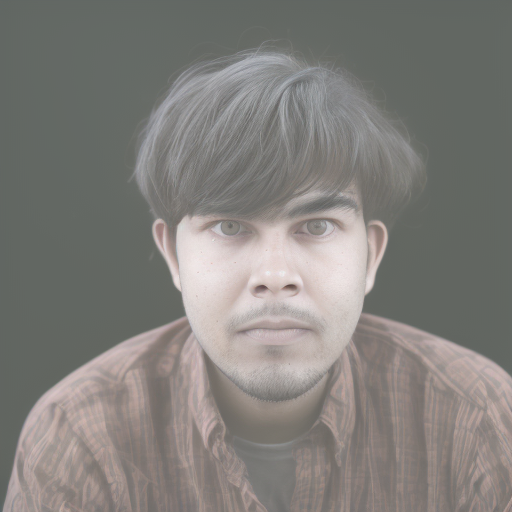

In [74]:
pipeline("a headshot of zwx man in analog style", num_inference_steps=50).images[0]